# Poc utilizando KNN para trabalho de conclusão de Ciência da computação da Feevale
## Carrega JSON

In [17]:
import json

users = {}

with open('spotify-plugin-app-export.json') as json_file:
    data = json.load(json_file)

    for userKey in data['events'].keys():
        user = data['events'][userKey]
        userEvents = []

        for key in user.keys():
            userEvents.append(user[key])

        users[userKey] = userEvents


for userKey in users.keys():
    print(f"len({userKey}) => {len(users[userKey])}")

len(spotify:user:16nxkn6lmlix2ou2w2rvodu3n) =&gt; 9
len(spotify:user:226rxsqefx3heakyeln7t3unq) =&gt; 27
len(spotify:user:22iwjt6kc4zv74sq7cutkhtwy) =&gt; 9
len(spotify:user:3152wu7mz2aoxfrg5mtqov77lseu) =&gt; 19
len(spotify:user:31bfdxg5fe2335adqfcg4xpugpcq) =&gt; 10
len(spotify:user:3ka2awymoso1wgdlwuq50uz8h) =&gt; 16
len(spotify:user:4i3jdhv6vubcjdpwsn38iv8u4) =&gt; 376
len(spotify:user:8q3uk0rwypu5r7dsq48476qak) =&gt; 5
len(spotify:user:andressltz) =&gt; 162
len(spotify:user:b8r2mhyhep5t0np1keaqmvvi0) =&gt; 20
len(spotify:user:gabrielcartelli) =&gt; 3
len(spotify:user:ggkonzen) =&gt; 12
len(spotify:user:iisa1999) =&gt; 326
len(spotify:user:iortim) =&gt; 174
len(spotify:user:jyangalonga) =&gt; 229
len(spotify:user:maiconunzer) =&gt; 7
len(spotify:user:o16tnkq56zdt2obwii1vgbs4o) =&gt; 5
len(spotify:user:tiagoterme) =&gt; 65


## Separa Contexto

In [18]:
import pandas as pd

usersContexts = {}

contexts = []
currentCtx = None

for event in users['spotify:user:4i3jdhv6vubcjdpwsn38iv8u4']:
    if event['action'] == "CHOOSE_FEELING":
        if currentCtx:
            contexts.append(currentCtx)

        currentCtx = {"musics": [], "info": {"feeling": event['value']}}
    elif event['action'] == "CHOOSE_ACTIVITY":
        currentCtx['info']['activity'] = event['value']
    elif event['action'] == "CHOOSE_LOCATION":
        currentCtx['info']['location'] = event['value']
    elif event['action'] == "LOAD_LOCATION":
        # currentCtx['info']['loaded_location'] = event['value']
        a = 0
    else:
        currentCtx['musics'].append(event)

contexts.append(currentCtx)

df=pd.DataFrame(contexts)

df.head()

musics  \
0  [{&#39;action&#39;: &#39;PLAY_MUSIC&#39;, &#39;createdDateTime&#39;: &#39;...   
1                                                 []   
2                                                 []   
3                                                 []   
4                                                 []   

                                                info  
0  {&#39;feeling&#39;: &#39;feliz;alegre&#39;, &#39;activity&#39;: &#39;estud...  
1  {&#39;feeling&#39;: &#39;feliz&#39;, &#39;activity&#39;: &#39;estudando&#39;, ...  
2  {&#39;feeling&#39;: &#39;alegre&#39;, &#39;activity&#39;: &#39;estudando&#39;,...  
3  {&#39;feeling&#39;: &#39;feliz&#39;, &#39;activity&#39;: &#39;estudando&#39;, ...  
4  {&#39;feeling&#39;: &#39;alegre;animada&#39;, &#39;activity&#39;: &#39;est...

## Separa contexto das musicas

In [19]:
musicTable = []
currentMusicCtx = None
lastMusic = None

for ctx in contexts:
    for music in ctx['musics']:
        if music['value'] != lastMusic:
            if lastMusic:
                currentMusicCtx.update(ctx['info'])
                musicTable.append(currentMusicCtx)
            
            lastMusic = music['value']
            currentMusicCtx = {'uri': music['value'], 'like': 0, 'hate':0, 'restart':0}

        if music['action'] == 'LIKED_MUSIC':
            currentMusicCtx['like'] += 1
        elif music['action'] == 'HATED_MUSIC':
            currentMusicCtx['hate'] += 1
        elif music['action'] == 'RESTART_MUSIC':
            currentMusicCtx['restart'] += 1

    currentMusicCtx.update(ctx['info'])
    musicTable.append(currentMusicCtx)


dfm=pd.DataFrame(musicTable)

dfm.head()

uri  like  hate  restart       feeling  \
0  spotify:track:29aSfWddeZJCfnrcMb20sy     1     0        0  feliz;alegre   
1  spotify:track:2evFJQfQVcDEXyOiyEV6OW     0     0        0  feliz;alegre   
2  spotify:track:6Te1vrlCz4DdCeONagkT6j     0     0        1  feliz;alegre   
3  spotify:track:5YrMcUZoNXlUCfwgnfocgL     0     0        0  feliz;alegre   
4  spotify:track:120w1eBYfiYrSXtegu6uEb     1     0        0  feliz;alegre   

    activity location  
0  estudando     casa  
1  estudando     casa  
2  estudando     casa  
3  estudando     casa  
4  estudando     casa

## busca informações das musicas

In [20]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from dotenv import load_dotenv # add this line

load_dotenv() # add this line

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=os.getenv('SPOTIFY_CLIENT_ID'),
                                                           client_secret=os.getenv('SPOTIFY_CLIENT_SECRET')))

musicsIds = list(map(lambda x : x['uri'], musicTable))

tracks = []
tracksMap = {}

i = 0

while i < len(musicsIds):
    ids = musicsIds[i:i + 50]
    response = sp.tracks(ids)
    tracks.extend(response['tracks'])
    i += 50

for track in tracks:
    tracksMap[track['uri']] = track

dft=pd.DataFrame(tracksMap)

dft

False   
name                                                 Best I Ever Had   
popularity                                                        52   
preview_url                                                     None   
track_number                                                       2   
type                                                           track   
uri                             spotify:track:120w1eBYfiYrSXtegu6uEb   

                                spotify:track:03nPEoQOYMuDe7KmGljpmd  \
album              {&#39;album_type&#39;: &#39;album&#39;, &#39;artists&#39;: [{&#39;external...   
artists            [{&#39;external_urls&#39;: {&#39;spotify&#39;: &#39;https://open.s...   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   260000   
explicit                                                        True   
external_ids                                {&#39;isrc&#39;: &#39;USSM11806283&#39;}   
external_urls      {&#39;spotify&#39;: &#39;https://open.spotify.com/track/03...   
href               https://api.spotify.com/v1/tracks/03nPEoQOYMuD...   
id                                            03nPEoQOYMuDe7KmGljpmd   
is_local                                                       False   
name               No Brainer (feat. Justin Bieber, Chance the Ra...   
popularity                                                        66   
preview_url        https://p.scdn.co/mp3-preview/607449ba733224db...   
track_number                                                      13   
type                                                           track   
uri                             spotify:track:03nPEoQOYMuDe7KmGljpmd   

                                spotify:track:6PYnUsNEpYC7A4BS2sjw3L  \
album              {&#39;album_type&#39;: &#39;single&#39;, &#39;artists&#39;: [{&#39;externa...   
artists            [{&#39;external_urls&#39;: {&#39;spotify&#39;: &#39;https://open.s...   
available_markets  [AD, AE, AL, AR, AT, AU, BA, BE, BG, BH, BO, B...   
disc_number                                                        1   
duration_ms                                                   254999   
explicit                                                       False   
external_ids                                {&#39;isrc&#39;: &#39;USRC11902029&#39;}   
external_urls      {&#39;spotify&#39;: &#39;https://open.spotify.com/track/6P...   
href               https://api.spotify.com/v1/tracks/6PYnUsNEpYC7...   
id                                            6PYnUsNEpYC7A4BS2sjw3L   
is_local                                                       False   
name                       Right Back (feat. A Boogie Wit Da Hoodie)   
popularity                                                        70   
preview_url        https://p.scdn.co/mp3-preview/276028634b0fdea7...   
track_number                                                       1   
type                                                           track   
uri                             spotify:track:6PYnUsNEpYC7A4BS2sjw3L   

                                spotify:track:50UkypyQJbSQLaXHke5Yep  \
album              {&#39;album_type&#39;: &#39;album&#39;, &#39;artists&#39;: [{&#39;external...   
artists            [{&#39;external_urls&#39;: {&#39;spotify&#39;: &#39;https://open.s...   
available_markets  [AD, AR, AT, AU, BA, BE, BG, BO, BR, CA, CH, C...   
disc_number                                                        1   
duration_ms                                                   180493   
explicit                                                        True   
external_ids                                {&#39;isrc&#39;: &#39;USUM70503011&#39;}   
external_urls      {&#39;spotify&#39;: &#39;https://open.spotify.com/track/50...   
href               https://api.spotify.com/v1/tracks/50UkypyQJbSQ...   
id              

## busca informações dos artistas (genero)

In [21]:
artistsIds = list(map(lambda x : x['artists'][0]['id'], tracks))

artists = []
artistsMap = {}

i = 0
while i < len(artistsIds):
    ids = artistsIds[i:i + 50]
    response = sp.artists(ids)
    artists.extend(response['artists'])
    i += 50

for artist in artists:
    artistsMap[artist['uri']] = artist

dfa=pd.DataFrame(artistsMap)

dfa

spotify:artist:2IvkS5MXK0vPGnwyJsrEyV  \
external_urls  {&#39;spotify&#39;: &#39;https://open.spotify.com/artist/2...   
followers                       {&#39;href&#39;: None, &#39;total&#39;: 2712611}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/2IvkS5MXK0v...   
id                                        2IvkS5MXK0vPGnwyJsrEyV   
images         [{&#39;height&#39;: 640, &#39;url&#39;: &#39;https://i.scdn.co/ima...   
name                                                 Eric Church   
popularity                                                    77   
type                                                      artist   
uri                        spotify:artist:2IvkS5MXK0vPGnwyJsrEyV   

                           spotify:artist:3THMgU4KdL7LlO5TEREs2g  \
external_urls  {&#39;spotify&#39;: &#39;https://open.spotify.com/artist/3...   
followers                        {&#39;href&#39;: None, &#39;total&#39;: 430688}   
genres         [country, country road, country rock, oklahoma...   
href           https://api.spotify.com/v1/artists/3THMgU4KdL7...   
id                                        3THMgU4KdL7LlO5TEREs2g   
images         [{&#39;height&#39;: 1500, &#39;url&#39;: &#39;https://i.scdn.co/im...   
name                                                  Joe Diffie   
popularity                                                    64   
type                                                      artist   
uri                        spotify:artist:3THMgU4KdL7LlO5TEREs2g   

                           spotify:artist:6yJCxee7QumYr820xdIsjo  \
external_urls  {&#39;spotify&#39;: &#39;https://open.spotify.com/artist/6...   
followers                       {&#39;href&#39;: None, &#39;total&#39;: 2340806}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/6yJCxee7Qum...   
id                                        6yJCxee7QumYr820xdIsjo   
images         [{&#39;height&#39;: 640, &#39;url&#39;: &#39;https://i.scdn.co/ima...   
name                                              Zac Brown Band   
popularity                                                    77   
type                                                      artist   
uri                        spotify:artist:6yJCxee7QumYr820xdIsjo   

                           spotify:artist:37W8SKV5Vc8lcGtdyWCA5m  \
external_urls  {&#39;spotify&#39;: &#39;https://open.spotify.com/artist/3...   
followers                        {&#39;href&#39;: None, &#39;total&#39;: 733341}   
genres         [contemporary country, country, country road, ...   
href           https://api.spotify.com/v1/artists/37W8SKV5Vc8...   
id                                        37W8SKV5Vc8lcGtdyWCA5m   
images         [{&#39;height&#39;: 640, &#39;url&#39;: &#39;https://i.scdn.co/ima...   
name                                                  Gary Allan   
popularity                                                    62   
type                                                      artist   
uri                        spotify:artist:37W8SKV5Vc8lcGtdyWCA5m   

                           spotify:artist:0QHgL1lAIqAw0HtD7YldmP  \
external_urls  {&#39;spotify&#39;: &#39;https://open.spotify.com/artist/0...   
followers                       {&#39;href&#39;: None, &#39;total&#39;: 5161097}   
genres         [dance pop, hip hop, miami hip hop, pop, pop r...   
href           https://api.spotify.com/v1/artists/0QHgL1lAIqA...   
id                                        0QHgL1lAIqAw0HtD7YldmP   
images         [{&#39;height&#39;: 640, &#39;url&#39;: &#39;https://i.scdn.co/ima...   
name                                                   DJ Khaled   
popularity                                                    87   
type                                                      artist   
uri                        spotify:artist:0QHgL1lAIqAw0HtD7YldmP   

                           spotify:artist:

## adiciona genero a tabela

In [22]:
for music in musicTable:
    artistId = tracksMap[music['uri']]['artists'][0]['uri']

    music['genre'] = artistsMap[artistId]['genres']

dfmg=pd.DataFrame(musicTable)

dfmg.head()

uri  like  hate  restart       feeling  \
0  spotify:track:29aSfWddeZJCfnrcMb20sy     1     0        0  feliz;alegre   
1  spotify:track:2evFJQfQVcDEXyOiyEV6OW     0     0        0  feliz;alegre   
2  spotify:track:6Te1vrlCz4DdCeONagkT6j     0     0        1  feliz;alegre   
3  spotify:track:5YrMcUZoNXlUCfwgnfocgL     0     0        0  feliz;alegre   
4  spotify:track:120w1eBYfiYrSXtegu6uEb     1     0        0  feliz;alegre   

    activity location                                              genre  
0  estudando     casa  [contemporary country, country, country road, ...  
1  estudando     casa  [country, country road, country rock, oklahoma...  
2  estudando     casa  [contemporary country, country, country road, ...  
3  estudando     casa  [contemporary country, country, country road, ...  
4  estudando     casa  [contemporary country, country, country road, ...

## trocar musica por genero

In [23]:
genreTable = []

for music in musicTable:
    for genre in music['genre']:
        newGenre = music.copy()

        del newGenre['uri']
        del newGenre['genre']

        newGenre['genre'] = genre

        genreTable.append(newGenre)

dfg=pd.DataFrame(genreTable)

dfg.head()

like  hate  restart       feeling   activity location                 genre
0     1     0        0  feliz;alegre  estudando     casa  contemporary country
1     1     0        0  feliz;alegre  estudando     casa               country
2     1     0        0  feliz;alegre  estudando     casa          country road
3     1     0        0  feliz;alegre  estudando     casa   modern country rock
4     0     0        0  feliz;alegre  estudando     casa               country

## Trata contextos duplicados (;)

In [24]:
def asd(key):
    print(f"before {key} len({len(genreTable)})")

    for i in range(len(genreTable)):
        genre = genreTable[i]
        ctxSplit = genre[key].split(";")
        genreTable.pop(i)

        for ctx in ctxSplit:
            genreCopy = genre.copy()
            genreCopy[key] = ctx
            genreTable.insert(i, genreCopy)

    print(f"after {key} len({len(genreTable)})")


asd("feeling")
asd("activity")
asd("location")

dfg=pd.DataFrame(genreTable)

dfg.head()

before feeling len(496)
after feeling len(697)
before activity len(697)
after activity len(905)
before location len(905)
after location len(905)


like  hate  restart feeling   activity location                 genre
0     1     0        0  alegre  estudando     casa  contemporary country
1     1     0        0   feliz  estudando     casa  contemporary country
2     1     0        0  alegre  estudando     casa               country
3     1     0        0   feliz  estudando     casa               country
4     1     0        0  alegre  estudando     casa          country road

## transformar labels

In [25]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

dfg['feeling'] = le.fit_transform(dfg['feeling'])
dfg['activity'] = le.fit_transform(dfg['activity'])
dfg['location'] = le.fit_transform(dfg['location'])

dfg.head()

like  hate  restart  feeling  activity  location                 genre
0     1     0        0        1         3         1  contemporary country
1     1     0        0       10         3         1  contemporary country
2     1     0        0        1         3         1               country
3     1     0        0       10         3         1               country
4     1     0        0        1         3         1          country road

## plotar

&lt;seaborn.axisgrid.PairGrid at 0x1a93f8ebc70&gt;

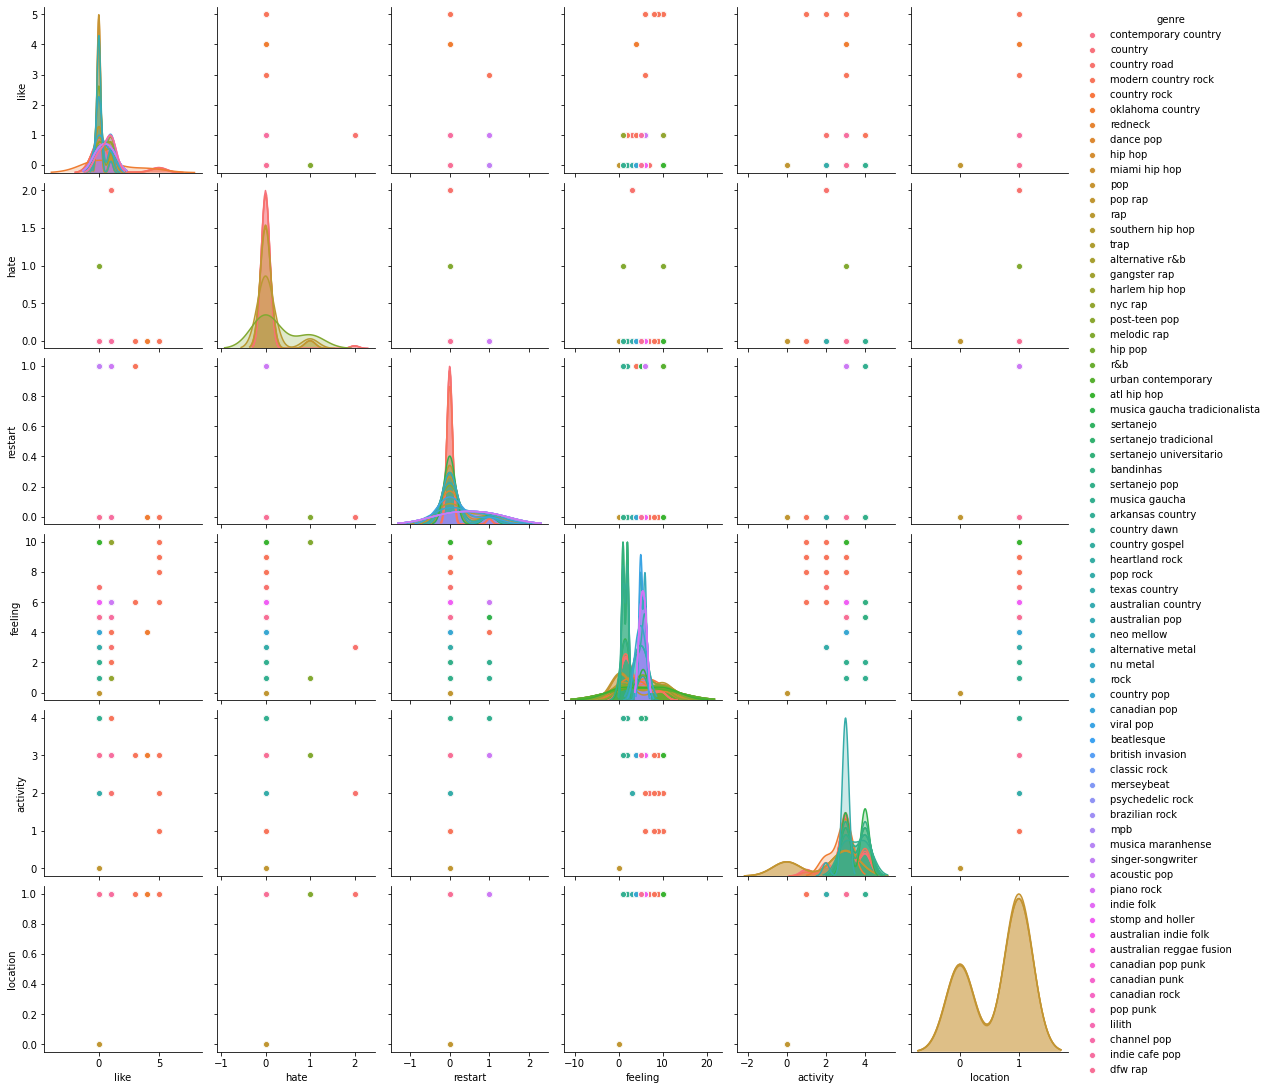

In [26]:
import seaborn as sns

sns.pairplot(dfg, hue="genre")

## knn 

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

model = KNeighborsClassifier(n_neighbors=3)

dfgCopy = dfg.copy()

del dfgCopy['genre']

labels = le.fit_transform(dfg['genre'])

X = dfgCopy[dfgCopy.columns[:]]
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

model.fit(X_train, y_train)

print(X_test)

result = model.predict(X_test)

print(result)

# print(dfg['genre'][result-1])

     like  hate  restart  feeling  activity  location
221     0     0        0        1         3         1
843     0     0        0        6         3         1
525     0     0        0        1         3         1
90      0     0        1        1         3         1
703     5     0        0        8         2         1
..    ...   ...      ...      ...       ...       ...
693     5     0        0        8         3         1
855     0     0        0        6         3         1
704     5     0        0        6         2         1
291     0     0        0        2         3         1
572     0     0        0        5         4         1

[272 rows x 6 columns]
[24 20 24 19 19  9 20 42 20 24  9 20 31 26 27 24 26 19 19 20 20 19  9 20
 26 20  0  9 26 26 20 20 24 20 20 24 24 26  9 19  9 42 19  9 20 24 24 39
 24 24 20 39  9  9 20 38  9  9  9 20  9  9 24 19 17 19 20 38 19  9 20 19
 20 24 24 20 20  9 26 26 20 19 24 24  2 26 24 19 24 18 20 20 20 42 26 19
 24 27 19 20  9  9 24 24 24 19 24 20

## Score KNN

In [32]:
model.score(X_test, y_test)

0.11397058823529412